In [4]:
import pandas as pd

# Load the tsv file
df = pd.read_csv('/Users/rajyalakshmigollakota/Downloads/deception_data_converted_final.tsv', 
                sep='\t')

# Examine the dataframe
print(df.shape)
print(df.describe())
df.head()

(92, 3)
       lie sentiment review
count   92        92     92
unique   2         2     91
top      t         p      ?
freq    46        46      2


,lie,sentiment,review
0,f,n,"'Mike\'s Pizza High Point, NY Service was very..."
1,f,n,'i really like this buffet restaurant in Marsh...
2,f,n,"'After I went shopping with some of my friend,..."
3,f,n,'Olive Oil Garden was very disappointing. I ex...
4,f,n,'The Seven Heaven restaurant was never known f...


     |████████████████████████████████| 220 kB 1.9 MB/s eta 0:00:01
  Created wheel for wordcloud: filename=wordcloud-1.8.1-cp38-cp38-macosx_10_9_x86_64.whl size=158812 sha256=fb5fb368334b3cf3ae518dfce5a837d95ec93e1ec8c32065e3dd240758254506
  Stored in directory: /Users/rajyalakshmigollakota/Library/Caches/pip/wheels/4d/3f/0d/a2ba9b7895c9f1be89018b3141c3df3d4f9c786c882ccfbc3b
Successfully built wordcloud


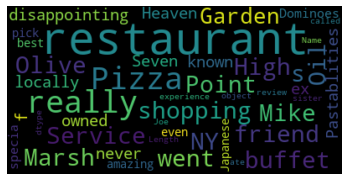

Word count before stop-words removal: 6971


In [6]:
# Let's see the initial word-cloud
! pip3 install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re

def make_wordcloud(review):
    wordcloud = WordCloud().generate(review)

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
make_wordcloud(str(df['review']))

# Gives us a fairly good idea that the reviews are based of restaurants. Also, see
# words like dissappointing & amazing which is reflective of mixed reviews.

# Step-1: Clean-out all the stop words in the review text
# Not too much in the wordcloud but to reduce feature-set during 
# vectorization, we will remove stopwords from text data. To quantify any 
# tangible benefits, we will record the word counts before vs after

def count_words(df):
    _len = 0
    for index in df.index:
        words = df['review'][index].split()
        _len += len(words)
    return _len

    
print('Word count before stop-words removal: %d' % count_words(df))

Word count after stop-words removal: 4176


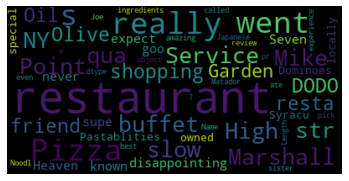

In [7]:
for index in df.index:
    words = df['review'][index].split()
    new_sent = ''
    for word in words:
        word = re.sub(',', '', word)
        if word in stopwords.words('english'):
            continue
        new_sent += ' ' + word
    df['review'][index] = new_sent

print('Word count after stop-words removal: %d' % count_words(df))

make_wordcloud(str(df['review']))

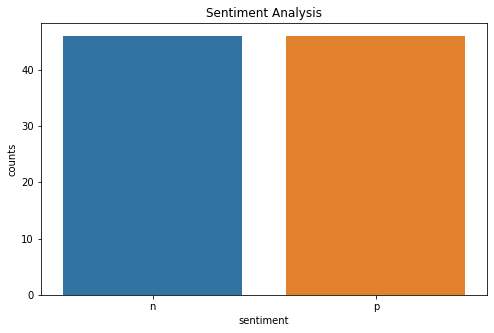

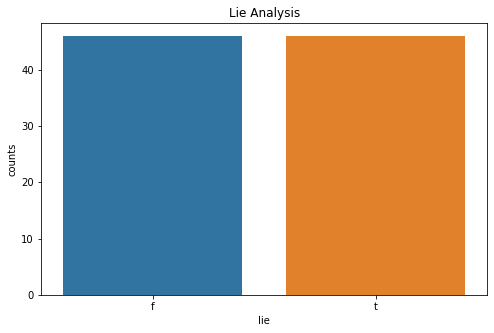

Fake and negative: 23
Fake and positive: 23
True and negative: 23
True and positive: 23


In [8]:
# Step-2: Let's see the overall sentiment and lie ratios
import matplotlib.pyplot as plt
import seaborn as sns

def plot_bar_graph(title, label_groups, x):
    plt.figure(figsize=(8,5))
    ax = sns.barplot(x=x, y="counts", data=label_groups)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.set_title(label="%s" %title)
    plt.show()


_labels = df.groupby('sentiment').size().reset_index(name='counts')
plot_bar_graph('Sentiment Analysis', _labels, 'sentiment')


_labels = df.groupby('lie').size().reset_index(name='counts')
plot_bar_graph('Lie Analysis', _labels, 'lie')

# Also, curious to see any correlation between the lie & sentiment
# did this.
fake_and_neg = df.loc[(df['lie'] == 'f') & (df['sentiment'] == 'n')]
print('Fake and negative: %s' % fake_and_neg.shape[0])

fake_and_pos = df.loc[(df['lie'] == 'f') & (df['sentiment'] == 'p')]
print('Fake and positive: %s' % fake_and_pos.shape[0])

true_and_neg = df.loc[(df['lie'] == 't') & (df['sentiment'] == 'n')]
print('True and negative: %s' % true_and_neg.shape[0])

true_and_pos = df.loc[(df['lie'] == 't') & (df['sentiment'] == 'p')]
print('True and positive: %s' % true_and_pos.shape[0])

# Conclusion about data:
# - Plotting the sentiment, lie shows that the labels/classification
# is fairly balanced 
# - Also, the fake and truth about reviews seems is perfectly distributed
# between postive and negative sentiment.
# This data has been curated or collected for a very specific reason and 
# may not therefore a good data-set to train models. Likely, we can see 
# overfitting.

In [9]:
# Step-3: We will now make two data-sets:
# - lie labels
# - sentiment labels

df_lie = pd.DataFrame(columns=['lie', 'review'])
df_lie['lie'] = df['lie']
df_lie['review'] = df['review']

# Finally, shuffle the data to randomize it sufficiently to prevent
# overfitting
df_lie = df_lie.sample(frac=1).reset_index(drop=True)

df_lie.head()

,lie,review
0,f,'The best dining experience I ever I dinner A...
1,f,'I went ultra-luxurious restaurant Downtown N...
2,f,'I ate restaurant called Banana Leaf. As I en...
3,f,'This restaurant AMAZING! I felt like life wo...
4,t,'I Asian restaurant New York city. The menu w...


In [12]:
df_sentiment = pd.DataFrame(columns=['sentiment', 'review'])
df_sentiment['sentiment'] = df['sentiment']
df_sentiment['review'] = df['review']

# Finally, shuffle the data to randomize it sufficiently to prevent
# overfitting

df_sentiment = df_sentiment.sample(frac=1).reset_index(drop=True)

df_sentiment.head()

,sentiment,review
0,n,'This place called Samarkand near SU Main Cam...
1,n,'After I went shopping friend went DODO resta...
2,n,'I went XYZ restaurant terrible experience. I...
3,n,'I went ABC restaurant two days ago I hated f...
4,p,'Two days ago I went rooftop restaurant NYC s...


In [19]:
# Since the data is mostly in terms of labels, we will normalize
# it using the vectorization method of TF-IDF.

# We will use the make_pipeline function. This will internally 
# transform the text data and then the model will be fitted using the transformed data.
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score


# Also, to prevent from overfitting we will use the k-folds methods
# to split the train, test data

from sklearn.model_selection import RepeatedKFold 
kf = RepeatedKFold(n_splits=10, n_repeats=10, random_state=None)

X = df_lie.iloc[:, -1]
y = df_lie.iloc[:, 0]

# Build the model
model_nb = make_pipeline(TfidfVectorizer(ngram_range=(1, 1)), 
                         MultinomialNB())

_sum = 0

for train_index, test_index in kf.split(X):
    
    X_train, X_test = X[train_index], X[test_index] 
    y_train, y_test = y[train_index], y[test_index]
    
    # Train the model using the training data
    model_nb.fit(X_train, y_train)
    
    # Predict the categories of the test data
    predicted_categories = model_nb.predict(X_test)
    
    _sum += accuracy_score(y_test, predicted_categories)
    
# Print the summary based on n_splits - here 5
test_accuracy = _sum/100

print(test_accuracy)

0.49477777777777804


In [26]:
# Repeat this for the sentiment data
from sklearn import metrics

X = df_sentiment.iloc[:, -1]
y = df_sentiment.iloc[:, 0]

_sum = 0

for train_index, test_index in kf.split(X):
    
    X_train, X_test = X[train_index], X[test_index] 
    y_train, y_test = y[train_index], y[test_index]
    
    # Train the model using the training data
    model_nb.fit(X_train, y_train)
    
    # Predict the categories of the test data
    predicted_categories = model_nb.predict(X_test)
    
    # Also, extract key metrics like confusion matrix, precision, recall etc.
    # in each iteration
    print(metrics.classification_report(y_test, predicted_categories))

    print(metrics.confusion_matrix(y_test, predicted_categories))
    
    _sum += accuracy_score(y_test, predicted_categories)
    
# Print the summary based on n_splits - here 5
test_accuracy = _sum/100

print('Accuracy (k-fold=10) for Naive Bayes = %s' % test_accuracy)

              precision    recall  f1-score   support

           n       1.00      0.83      0.91         6
           p       0.80      1.00      0.89         4

    accuracy                           0.90        10
   macro avg       0.90      0.92      0.90        10
weighted avg       0.92      0.90      0.90        10

[[5 1]
 [0 4]]
              precision    recall  f1-score   support

           n       1.00      0.80      0.89         5
           p       0.83      1.00      0.91         5

    accuracy                           0.90        10
   macro avg       0.92      0.90      0.90        10
weighted avg       0.92      0.90      0.90        10

[[4 1]
 [0 5]]
              precision    recall  f1-score   support

           n       0.43      1.00      0.60         3
           p       1.00      0.33      0.50         6

    accuracy                           0.56         9
   macro avg       0.71      0.67      0.55         9
weighted avg       0.81      0.56      0.53 


[[5 1]
 [0 3]]
              precision    recall  f1-score   support

           n       0.80      1.00      0.89         4
           p       1.00      0.80      0.89         5

    accuracy                           0.89         9
   macro avg       0.90      0.90      0.89         9
weighted avg       0.91      0.89      0.89         9

[[4 0]
 [1 4]]
              precision    recall  f1-score   support

           n       1.00      1.00      1.00         7
           p       1.00      1.00      1.00         3

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10

[[7 0]
 [0 3]]
              precision    recall  f1-score   support

           n       1.00      0.57      0.73         7
           p       0.50      1.00      0.67         3

    accuracy                           0.70        10
   macro avg       0.75      0.79      0.70        10
weighted avg       0.85     

              precision    recall  f1-score   support

           n       1.00      0.67      0.80         3
           p       0.86      1.00      0.92         6

    accuracy                           0.89         9
   macro avg       0.93      0.83      0.86         9
weighted avg       0.90      0.89      0.88         9

[[2 1]
 [0 6]]
              precision    recall  f1-score   support

           n       1.00      0.57      0.73         7
           p       0.40      1.00      0.57         2

    accuracy                           0.67         9
   macro avg       0.70      0.79      0.65         9
weighted avg       0.87      0.67      0.69         9

[[4 3]
 [0 2]]
              precision    recall  f1-score   support

           n       1.00      0.80      0.89         5
           p       0.80      1.00      0.89         4

    accuracy                           0.89         9
   macro avg       0.90      0.90      0.89         9
weighted avg       0.91      0.89      0.89 

In [21]:
# Now try the same experiment with Support Vector Machines(SVM). SVM is 
# regarded as the best text classification algorithm although it could be
# slower than Naive Bayes. 

# Let's build the pipeline for this
from sklearn.linear_model import SGDClassifier

X = df_sentiment.iloc[:, -1]
y = df_sentiment.iloc[:, 0]


# Build the model
model_sgd = make_pipeline(TfidfVectorizer(ngram_range=(1, 1)), 
                          SGDClassifier())

_sum = 0

for train_index, test_index in kf.split(X):
    
    X_train, X_test = X[train_index], X[test_index] 
    y_train, y_test = y[train_index], y[test_index]
    
    # Train the model using the training data
    model.fit(X_train, y_train)
    
    # Predict the categories of the test data
    predicted_categories = model.predict(X_test)
    
    _sum += accuracy_score(y_test, predicted_categories)
    
# Print the summary based on n_splits - here 5
test_accuracy_sgd = _sum/100

print(test_accuracy_sgd)

0.8176666666666663
